# My implementation of Actor-Critic Method

In this file, I will use the Panda-Robotics to evaluate my agent's perfermance

## import some packages and check the env

*Remerber:* we need to install panda_gym

*pip install panda_gym*

In [71]:
import gymnasium as gym
import numpy as np
# these are new packages in this file
import panda_gym
import stable_baselines3
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.env_util import make_vec_env
from collections import deque
import matplotlib.pyplot as plt
%matplotlib inline

In [72]:
env_id = 'PandaReachDense-v3'
env = gym.make(env_id)
state_space = env.observation_space
action_space = env.action_space.shape
print(f'state space: {state_space}')
print(f'action space: {action_space}')

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886
state space: Dict('achieved_goal': Box(-10.0, 10.0, (3,), float32), 'desired_goal': Box(-10.0, 10.0, (3,), float32), 'observation': Box(-10.0, 10.0, (6,), float32))
action space: (3,)


In [73]:
env = make_vec_env(env_id, n_envs=1)

env = VecNormalize(env, norm_obs=True, norm_reward=True, clip_obs=10.)

obs = env.reset()

achieved_goal = obs['achieved_goal']
desired_goal = obs['desired_goal']
observation = obs['observation']

merged_array = np.concatenate([achieved_goal, desired_goal, observation], axis=-1)
merged_array.shape

argv[0]=--background_color_red=0.8745098114013672
argv[1]=--background_color_green=0.21176470816135406
argv[2]=--background_color_blue=0.1764705926179886


(1, 12)

In [74]:
env.action_space.shape[0]

3

## Build compentes of the A2C algorithm

1. Actor Network

2. Value-function Network

There are serval common baseline

1. REINFORCE

2. Q Actor-Critic

3. Advantage Actor-Critic

4. TD Actor-Critic

In [75]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
# we don't use the Categorical since the actions are continuous
# we should use the Normal to model the continous distribution
from torch.distributions import Categorical,Normal

In [76]:
# we conbine the actornetwork and criticnetwork into a whole network
class ActorCritic(nn.Module):
    """This network includes a net to output action and a net to output value"""
    def __init__(
        self,
        state_space,
        action_space,
        lr,
        device,
        fc1_unit = 64,
        fc2_unit = 64
    ):
        super(ActorCritic,self).__init__()
        self.state_space = state_space
        self.action_space = action_space
        self.lr = lr
        self.device = device
        
        # nn.Sequential is really helpful
        # Actor
        self.actor = nn.Sequential(
            nn.Linear(state_space,fc1_unit),
            # in the sequential we should use the nn.ReLU() instead of torch.nn.functional.relu()
            # cause nn.ReLU is a module while functional.relu is a independent function
            nn.ReLU(),
            nn.Linear(fc1_unit,fc2_unit),
            nn.ReLU(),
            # action_space * 2: we aim to output the mean and std of the action distribution
            nn.Linear(fc2_unit,action_space*2)
        )
        
        # Critic
        self.critic = nn.Sequential(
            nn.Linear(state_space,fc1_unit),
            nn.ReLU(),
            nn.Linear(fc1_unit,fc2_unit),
            nn.ReLU(),
            nn.Linear(fc2_unit,1) # output the value
        )
        
        self.optimizer = optim.Adam(self.parameters(),lr = lr)
        self.to(self.device)
        
    def forward(self,state):

        value = self.critic(state)
        
        # output the mean and std of action distribution
        x = self.actor(state)
        # why log_std?
        # because the log_std is (-infinite, +infinite)
        mean,log_std = x[:,:self.action_space], x[:,self.action_space:]
        return value,mean,log_std
    
    def process_input(self,x):
        achieved_goal = x['achieved_goal']
        desired_goal = x['desired_goal']
        observation = x['observation']
        merged_array = np.concatenate([achieved_goal, desired_goal, observation], axis=-1)
        state = torch.from_numpy(merged_array).float()
        return state

## build an agent and play the game

![algorithm_figure](/Users/gaohaitao/robotics-tutorial/Algotithms/A2C.png)

*This picture is from https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f*

In [77]:
class Agent():
    def __init__(
        self,
        env: gym.envs,
        state_space: int,
        action_space: int,
        lr: float,
        device: torch.device,
        gamma: float, # discounted rewards
        n_training_episodes: int,
        max_t: int
    ):
        # init the variables
        self.env = env
        self.state_space = state_space
        self.action_space = action_space
        self.lr = lr
        self.device = device
        self.gamma = gamma
        self.n_training_episodes = n_training_episodes
        self.max_t = max_t
        
        self.actor_critic = ActorCritic(state_space,action_space,
                                        lr,device)
        
    def act(self,state):
        # choose an action given a state
        ## Firstly, we should convert the state to torch.tensor since we need use GPU to train
        ## This is new to the code because the input state is a Dict
        ## The dict includes 'observation', 'achieved_goal', 'desired_goal'
        achieved_goal = state['achieved_goal']
        desired_goal = state['desired_goal']
        observation = state['observation']
        merged_array = np.concatenate([achieved_goal, desired_goal, observation], axis=-1)
        state = torch.from_numpy(merged_array).float().to(self.device)
        # the operation of sampling action is different with previous codes
        # we need use the Normal() to model the distribution using mean and log_std
        # then, sample the action
        value,mean,log_std = self.actor_critic(state)
        # convert log_std to std
        std = torch.exp(log_std)
        normal = Normal(mean,std)
        action = normal.sample()
        log_prob = normal.log_prob(action)
        return action.numpy(),log_prob
    
    def step(self,action):
        # the agent take the action and obtain the next observation and immedient reward
        next_obs,reward,terminated,truncated = self.env.step(action)
        done = terminated or truncated
        return next_obs, reward, done
    
    def update(self,advantage,log_prob):
        """this is different with previous codes because we need to update two networks at each time_step"""
        # Note that Variable 'advantages' must be tensor
        policy_loss = -torch.mean(advantage * log_prob)
        value_loss = advantage
        
        total_loss = policy_loss + value_loss
        
        self.actor_critic.optimizer.zero_grad()
        total_loss.backward()
        self.actor_critic.optimizer.step()
        
    def train(self):
        """the agent will play many episodes and update it's parameters"""
        scores_deque = deque(maxlen=100)
        scores = []
        avg_scores = []
        
        for episode in range(self.n_training_episodes):
            # init some lists to store the infos
            rewards = []
            # in this method, we don't need to init saved_log_probs and rewards
            # since we update the network at each timestep
            # only need the immedient reward and predition of value
            
            # init the env where there isn't info
            state = self.env.reset()
            
            # loop max_t
            for t in range(self.max_t):
                # sample an action
                action,log_prob = self.act(state)
                # stepforward
                next_obs,reward,done = self.step(action)
                rewards.append(reward)
                # compute the advantage function
                # A = r + gamma * V(next) - V(now)
                value,_,_ = self.actor_critic(self.actor_critic.process_input(state))
                value_,_,_ = self.actor_critic(self.actor_critic.process_input(next_obs))
                advantage = torch.tensor(reward).float() + self.gamma * value_ - value
                self.update(advantage,log_prob)
                
                if done:
                    break
                
                state = next_obs
            
            scores_deque.append(sum(rewards))
            scores.append(sum(rewards))
            avg_scores.append(np.mean(scores_deque))
            
            if episode % 1 == 0:
                print(f'episode: {episode} | average score: {np.mean(scores_deque)}')
                
        fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
        fig.suptitle('Training Progress')

        ax1.plot(scores, label='Episode Scores', color='b')
        ax1.set_xlabel('Episode')
        ax1.set_ylabel('scores', color='b')
        ax1.tick_params(axis='y', labelcolor='b')

        ax2.plot(avg_scores, label='Episode Average Score', color='r')
        ax2.set_xlabel('Episode')
        ax2.set_ylabel('Average Score', color='r')
        ax2.tick_params(axis='y', labelcolor='r')
        
        

In [78]:
# Hyperparameters
state_space = merged_array.shape[-1]
action_space = env.action_space.shape[0]
lr = 1e-2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
gamma = 1.0
n_training_episodes = 300
max_t = 10000

RoboticsAgent = Agent(
    env,
    state_space,
    action_space,
    lr,
    device,
    gamma,
    n_training_episodes,
    max_t
)

episode: 0 | average score: -10.0
episode: 1 | average score: -5.306158542633057
episode: 2 | average score: -4.138797283172607
episode: 3 | average score: -3.897042751312256
episode: 4 | average score: -3.708477020263672
episode: 5 | average score: -3.5974979400634766
episode: 6 | average score: -3.2593092918395996
episode: 7 | average score: -3.1120941638946533
episode: 8 | average score: -2.9695651531219482
episode: 9 | average score: -2.9783756732940674
episode: 10 | average score: -2.9281563758850098
episode: 11 | average score: -2.8155462741851807
episode: 12 | average score: -2.8353826999664307
episode: 13 | average score: -2.866875410079956
episode: 14 | average score: -2.9501655101776123
episode: 15 | average score: -3.0163800716400146
episode: 16 | average score: -3.0912628173828125
episode: 17 | average score: -3.007777214050293
episode: 18 | average score: -2.9756977558135986
episode: 19 | average score: -3.055102825164795
episode: 20 | average score: -2.9614245891571045
ep

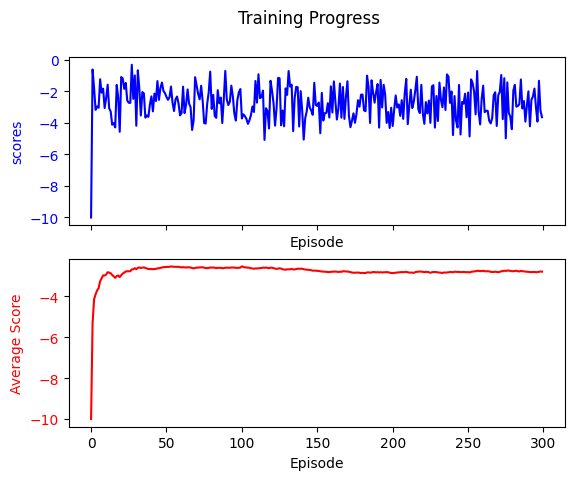

In [79]:
RoboticsAgent.train()